# Variational autoencoder (using the VAE class)
PixyzのModel APIに用意されている，VAEクラスを用いて，VanillaなVAEを実装してみましょう．

出典: https://github.com/masa-su/pixyz/blob/master/examples/vae.ipynb

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tensorboardX import SummaryWriter
from tqdm import tqdm

batch_size = 128
epochs = 5
seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

%matplotlib inline

In [2]:
root = 'data'
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambd=lambda x: x.view(-1))])
kwargs = {'batch_size': batch_size, 'num_workers': 1, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root=root, train=True, transform=transform, download=True),
    shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root=root, train=False, transform=transform),
    shuffle=False, **kwargs)

### 0) Pixyzのimport
今回は，VAEをModel APIを使って実装します．

VAEの事前分布とエンコーダには正規分布，デコーダにはベルヌーイ分布を利用します．
- 事前分布は平均が0，標準偏差が1の標準正規分布を用います(なのでlocとscaleが定数)

In [3]:
from pixyz.distributions import Normal, Bernoulli
from pixyz.losses import KullbackLeibler
from pixyz.models import VAE

### 1) 分布の定義
Pixyzの分布クラスを継承してネットワークを書いてゆきます．

cond_varには分布で条件付ける確率変数，varには分布の確率変数を指定します．
- つまり，分布の入力はcond_varで条件付けた変数になります

forwardで，分布のパラメータの値をdictで返すようにします．
- ガウス分布の場合，平均(loc)と標準偏差(scale)
- ベルヌーイ分布の場合，確率(probs)

【ポイント！】 nameで分布に名前を与えておくと，あとで見直しやすくなります．

In [4]:
x_dim = 784
z_dim = 64


# inference model q(z|x)
class Inference(Normal):
    def __init__(self):
        super(Inference, self).__init__(cond_var=["x"], var=["z"], name="q")

        self.fc1 = nn.Linear(x_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc31 = nn.Linear(512, z_dim)
        self.fc32 = nn.Linear(512, z_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}

    
# generative model p(x|z)    
class Generator(Bernoulli):
    def __init__(self):
        super(Generator, self).__init__(cond_var=["z"], var=["x"], name="p")

        self.fc1 = nn.Linear(z_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, x_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return {"probs": torch.sigmoid(self.fc3(h))}
    
    
# prior model p(z)
loc = torch.tensor(0.).to(device)
scale = torch.tensor(1.).to(device)
prior = Normal(loc=loc, scale=scale, var=["z"], dim=z_dim, name="p_prior")

#### 分布のインスタンスの作成・deviceの指定

In [5]:
p = Generator().to(device)
q = Inference().to(device)

【ポイント！】 分布をprintするとその分布の中身のネットワークがどうなっているか確認できます．

In [6]:
print(p)
print(q)

Distribution:
  p(x|z) (Bernoulli)
Network architecture:
  Generator(
    (fc1): Linear(in_features=64, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=784, bias=True)
  )
Distribution:
  q(z|x) (Normal)
Network architecture:
  Inference(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc31): Linear(in_features=512, out_features=64, bias=True)
    (fc32): Linear(in_features=512, out_features=64, bias=True)
  )


### 2) 目的関数の設定
今回は，Model APIに用意されているVAEクラスを用いて実装を行ってみましょう．

VAEクラスは，エンコーダからサンプルされた潜在変数zを使ってデコーダで入力を再構成するときの誤差を最小化するようなモデルです．

通常のVAEのLossは
$$
\mathcal { L } _ { \mathrm { VAE } } ( \theta , \phi ) =   \mathbb { E } _ { q _ { \phi } ( z | x ) } \left[ - \log p _ { \theta } ( x | z ) \right] + D _ { \mathrm { KL } } \left( q _ \phi ( z | x ) \| p ( z ) \right)
$$
のように表せますから，正則化項としてエンコーダと事前分布のKLダイバージェンスを指定します．

In [7]:
kl = KullbackLeibler(q, prior)

【ポイント！】 Lossをprintするとそのロスの式を確認できます．

In [8]:
print(kl)

KL[q(z|x)||p_prior(z)]


VAEクラスは，1つ目の引数にエンコーダの分布，2つ目の引数にデコーダの分布をとります．正則化項は，`regularizer`で指定します．

また．学習時のoptimizerもここで指定できます(デフォルトはAdamです)．

VAEクラスがとる引数の詳細は．https://pixyz.readthedocs.io/en/latest/models.html#vae　を見てください．
- ipythonやJupyterを利用している場合は， `VAE?` で引数を確認することもできます．

In [9]:
model = VAE(q, p, regularizer=kl, optimizer=optim.Adam, optimizer_params={"lr":1e-3})

【ポイント！】 モデルをprintすると，学習に用いられている分布，Lossの式，optimizerの設定を確認できます．

In [10]:
print(model)

Distributions (for training): 
  q(z|x), p(x|z) 
Loss function: 
  mean(-E_q(z|x)[log p(x|z)] + KL[q(z|x)||p_prior(z)]) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.001
      weight_decay: 0
  )


### 学習してみる
それでは実際に学習してみましょう．

モデルクラスには，`train()`メソッドが用意されており，その引数に入力を与えるだけで，内部でlossを`backward()`して,パラメータを更新(`optimizer.step()`)してくれます．

`test()`メソッドでは，引数として与えられた入力に対するLossを返します．

In [11]:
def train(epoch):
    train_loss = 0
    for x, _ in tqdm(train_loader):
        x = x.to(device)
        loss = model.train({"x": x})
        train_loss += loss
 
    train_loss = train_loss * train_loader.batch_size / len(train_loader.dataset)
    print('Epoch: {} Train loss: {:.4f}'.format(epoch, train_loss))
    return train_loss

In [12]:
def test(epoch):
    test_loss = 0
    for x, _ in test_loader:
        x = x.to(device)
        loss = model.test({"x": x})
        test_loss += loss

    test_loss = test_loss * test_loader.batch_size / len(test_loader.dataset)
    print('Test loss: {:.4f}'.format(test_loss))
    return test_loss

In [13]:
def plot_reconstrunction(x):
    with torch.no_grad():
        z = q.sample({"x": x}, return_all=False)
        recon_batch = p.sample_mean(z).view(-1, 1, 28, 28)
    
        comparison = torch.cat([x.view(-1, 1, 28, 28), recon_batch]).cpu()
        return comparison
    
def plot_image_from_latent(z_sample):
    with torch.no_grad():
        sample = p.sample_mean({"z": z_sample}).view(-1, 1, 28, 28).cpu()
        return sample

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

100%|██████████| 469/469 [00:08<00:00, 52.12it/s]

Epoch: 1 Train loss: 178.9727


Test loss: 142.6261
再構成:


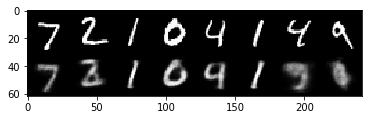

事前分布からのサンプル:


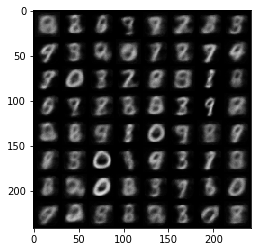

100%|██████████| 469/469 [00:08<00:00, 54.77it/s]


Epoch: 2 Train loss: 129.9609
Test loss: 121.8271
再構成:


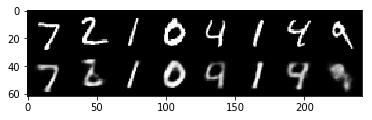

事前分布からのサンプル:


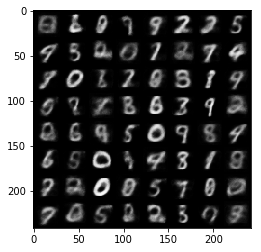

100%|██████████| 469/469 [00:08<00:00, 56.16it/s]


Epoch: 3 Train loss: 117.6172
Test loss: 114.7299
再構成:


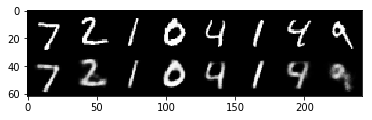

事前分布からのサンプル:


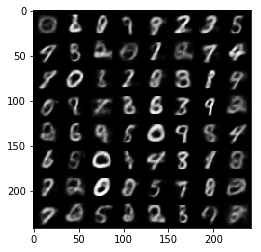

100%|██████████| 469/469 [00:08<00:00, 53.24it/s]

Epoch: 4 Train loss: 112.6120


Test loss: 111.1166
再構成:


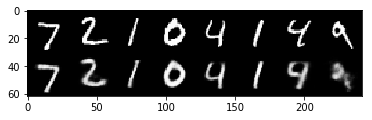

事前分布からのサンプル:


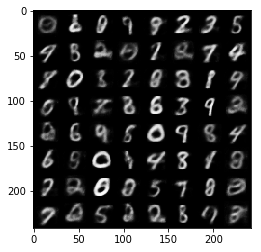

100%|██████████| 469/469 [00:08<00:00, 52.27it/s]

Epoch: 5 Train loss: 109.8360


Test loss: 109.2788
再構成:


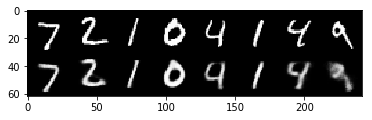

事前分布からのサンプル:


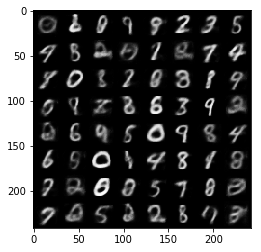

In [14]:
writer = SummaryWriter()

z_sample = 0.5 * torch.randn(64, z_dim).to(device)
_x, _ = iter(test_loader).next()
_x = _x.to(device)

for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    
    recon = plot_reconstrunction(_x[:8])
    sample = plot_image_from_latent(z_sample)
    writer.add_scalar('train_loss', train_loss.item(), epoch)
    writer.add_scalar('test_loss', test_loss.item(), epoch)      
    
    writer.add_image('Image_from_latent', sample[0], epoch)
    writer.add_image('Image_reconstrunction', recon[0], epoch)
    print('再構成:')
    imshow(torchvision.utils.make_grid(recon))
    print('事前分布からのサンプル:')
    imshow(torchvision.utils.make_grid(sample))
writer.close()